In [288]:
import pylatexenc
import numpy as np
import qiskit
from qiskit.quantum_info import Operator
from qiskit.circuit.library import UnitaryGate

import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint

import pandas as pd
from fractions import Fraction
import math

In [359]:
N = int(input())

In [360]:
N

21

In [361]:
def qft_dagger(n):
    qc = QuantumCircuit(n)

    for qubit in range(n // 2):
        qc.swap(qubit, n - qubit - 1)
    qc.barrier()
    
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2 ** (j - m)), m, j)
    qc.barrier()
    
    for j in range(n):
        qc.h(j)
    qc.barrier()
    qc.name = "QFT Dagger"

    return qc

In [362]:
def makeUunitary(A):
    A_ = A.T

    for i in range(A.shape[0]):
        if (np.linalg.norm(A[i]) == 0) and (np.linalg.norm(A_[i]) == 0):
            A[i][i] = 1

In [374]:
def ShorFactoring(N):
    factors = []

    # # Step 1
    # while (N % 2) == 0:
    #     factors.append(2)
    #     N = N // 2
    
    # if N == 1:
    #     return factors
    
    # # Step 2: N = a^b
    # pass
    
    # # Step 3
    a = randint(2, N)
    a = 20

    while math.gcd(a, N) > 1:
        factors.append(math.gcd(a, N))
        N //= math.gcd(a, N)
        print(N)

        if N > 1:
            a = randint(2, N)
    
    # Step 4: Order finding: find order r of x modulo N
    n_qubits = math.floor(math.log(N, 2)) + 1
    qc_main = QuantumCircuit(2 * n_qubits, n_qubits)
    for i in range(n_qubits):
        qc_main.h(i)
    qc_main.x(2*n_qubits - 1)
    qc_main.barrier()

    # U operations
    U = np.zeros((2**n_qubits, 2**n_qubits))
    U[1][a] = 1
    for pow in range(1, 2**n_qubits):
        U[(a**pow)%N][(a**(pow + 1))%N] = 1 # Can optimize using modular exponentiation; DP concept(s)

    makeUunitary(U)

    if np.array_equal(U@(U.T), np.eye(2**n_qubits)) is False:
        print(U)
        print(U.T)
        raise Exception("Some error occurred in calculating the U operator")

    U = U.T
    opU = UnitaryGate(U)
    opU = opU.control(1)

    for pow in range(n_qubits):
        for t in range(2**pow):
            wires = [i for i in range(n_qubits, 2*n_qubits)]
            wires.insert(0, pow)
            qc_main.append(opU, wires)

    qc_main.barrier()

    qc_main.append(qft_dagger(n_qubits), [i for i in range(n_qubits)])
    qc_main.barrier()

    qc_main.measure([i for i in range(n_qubits)], [i for i in range(n_qubits)])

    %matplotlib inline
    qc_main.draw('mpl')

    return a, factors, qc_main, U, N

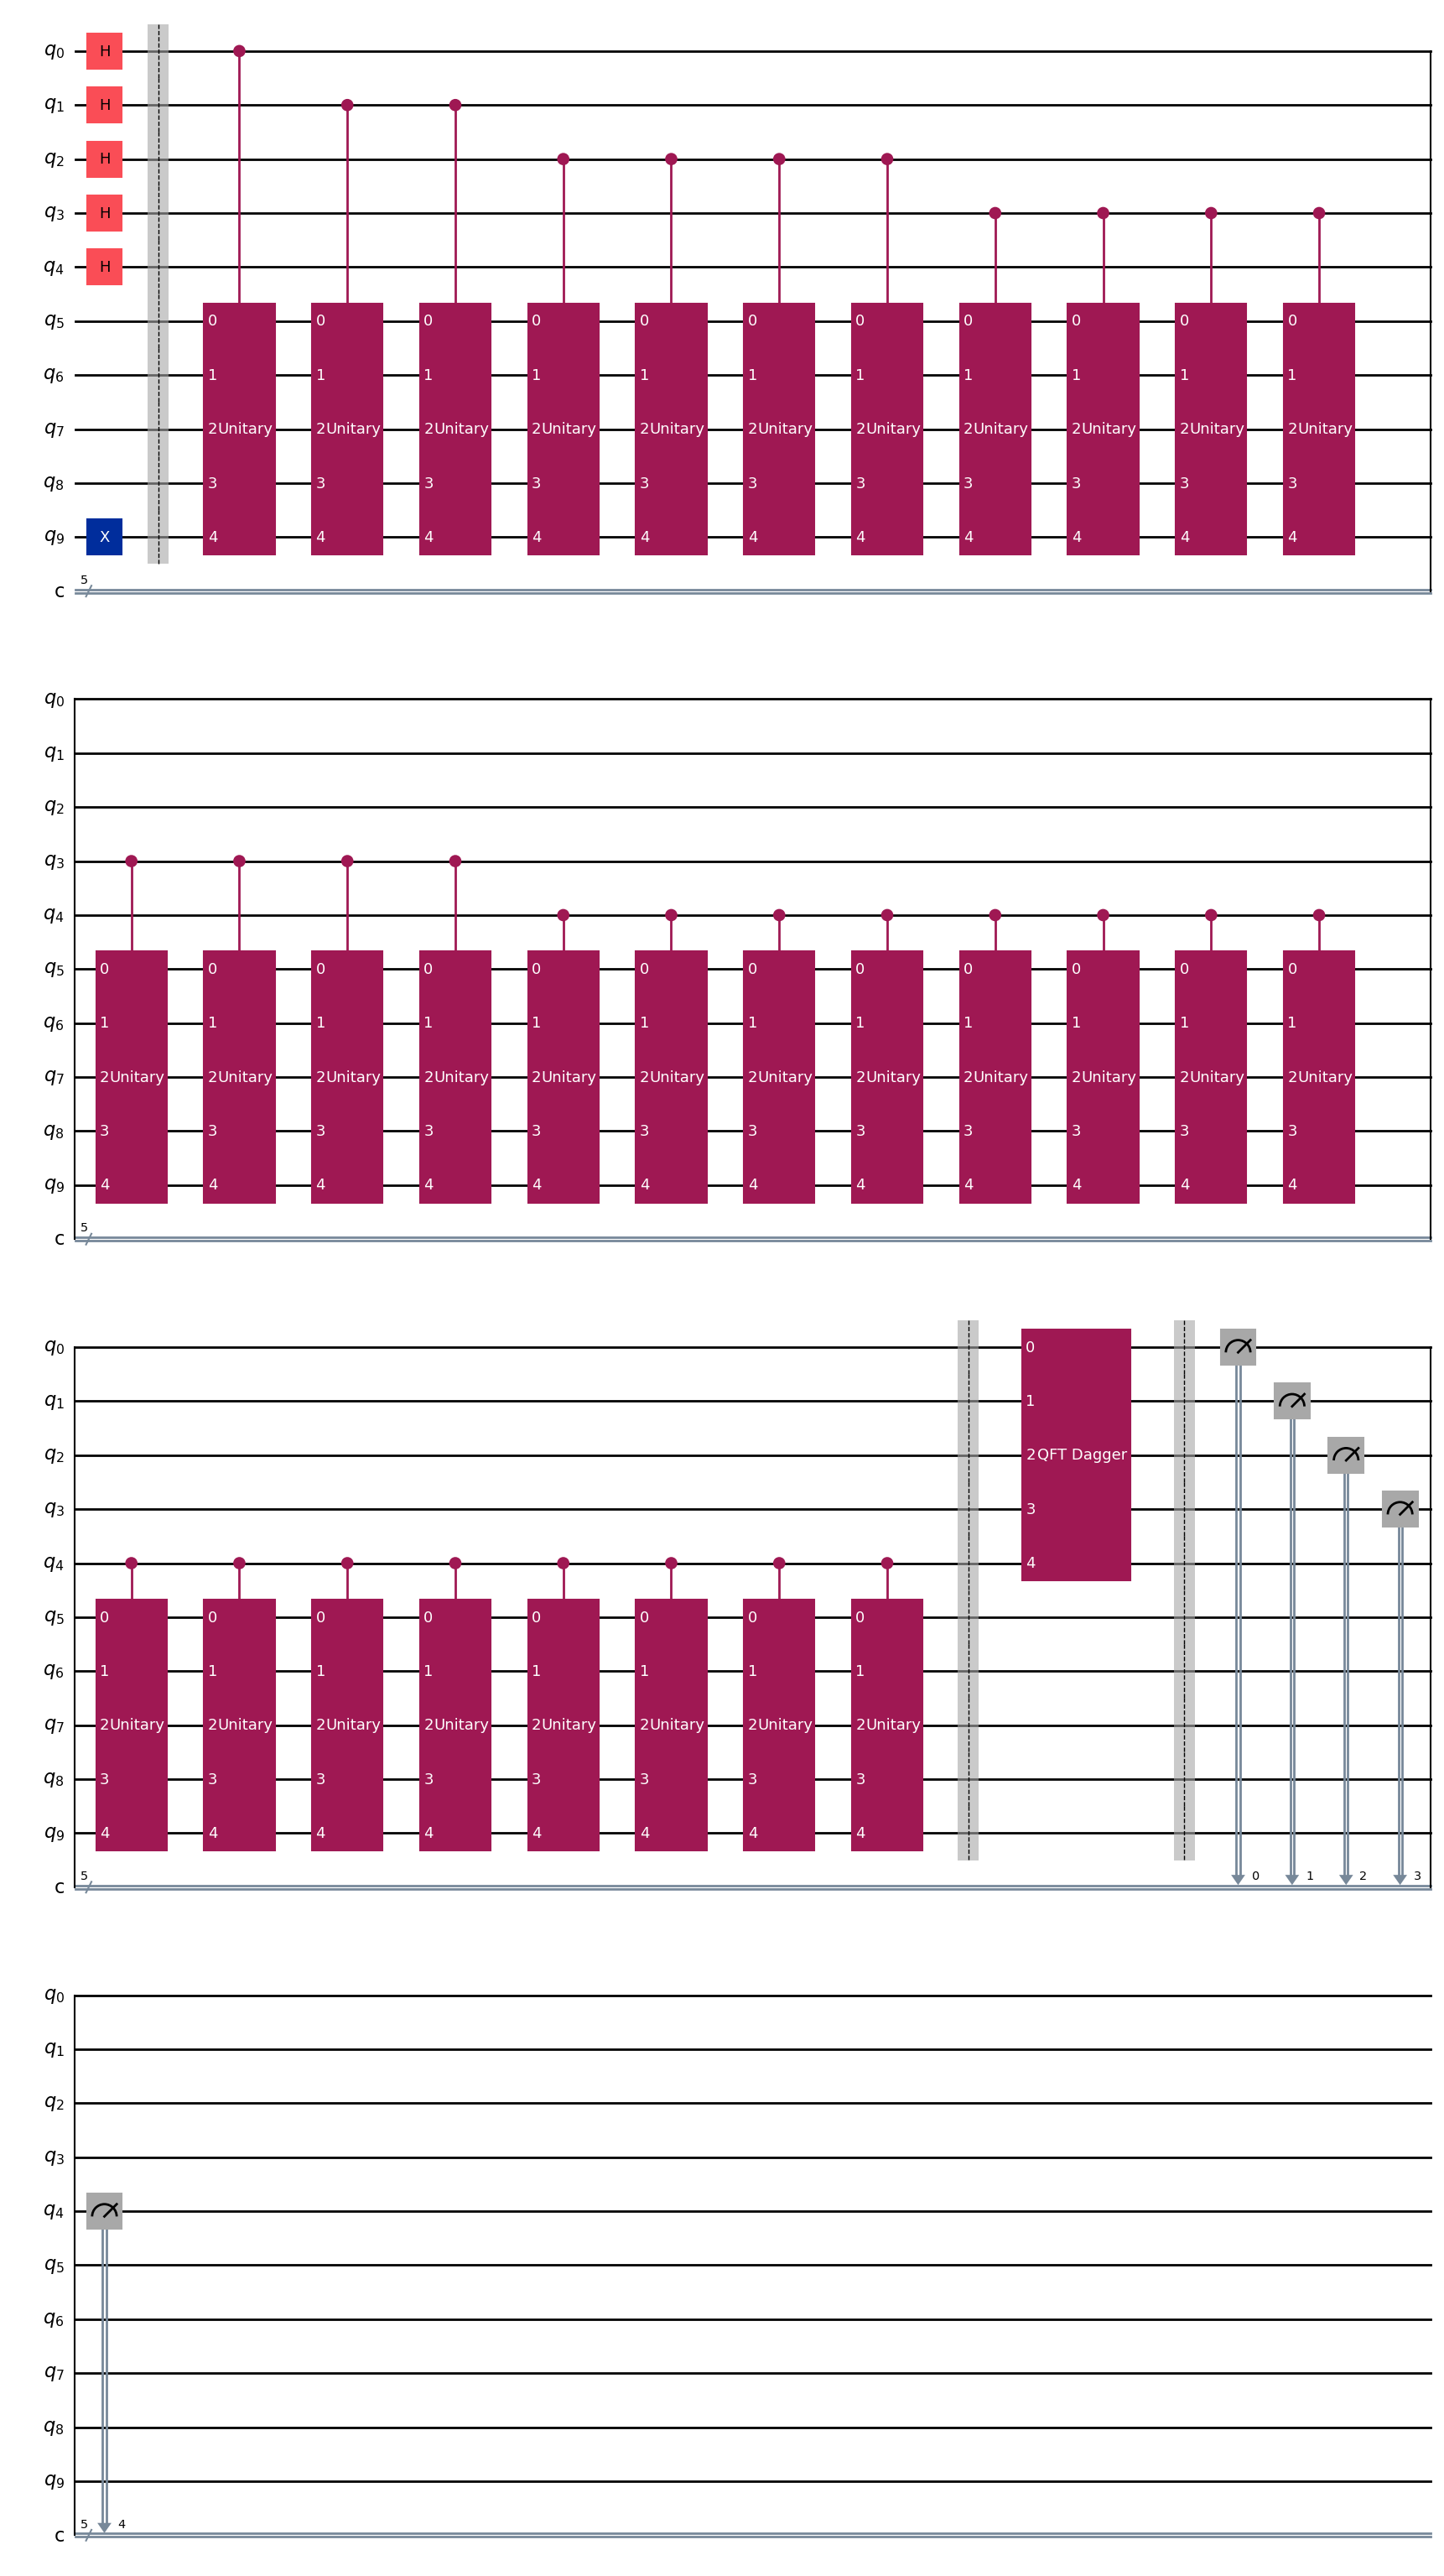

In [375]:
a_inner, factors_, qc_inner, U_inner, N_inner = ShorFactoring(N)

In [376]:
print(N, a_inner, factors_)

21 20 []


In [377]:
from qiskit_aer import Aer
from qiskit import transpile
simulator = Aer.get_backend('qasm_simulator')
# counts = execute(mycircuit, backend=simulator, shots=1000).result().get_counts(mycircuit)

new_circuit = transpile(qc_inner, simulator)
counts = simulator.run(new_circuit).result().get_counts()

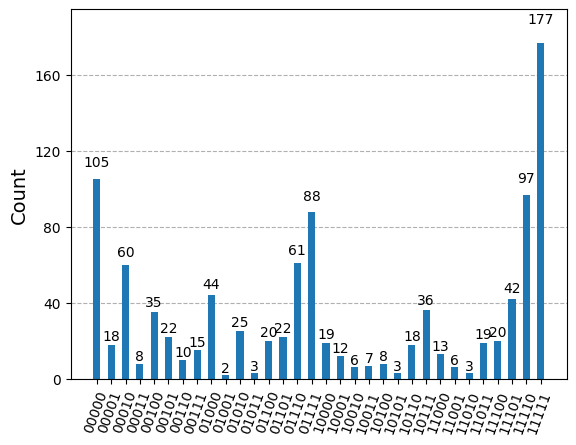

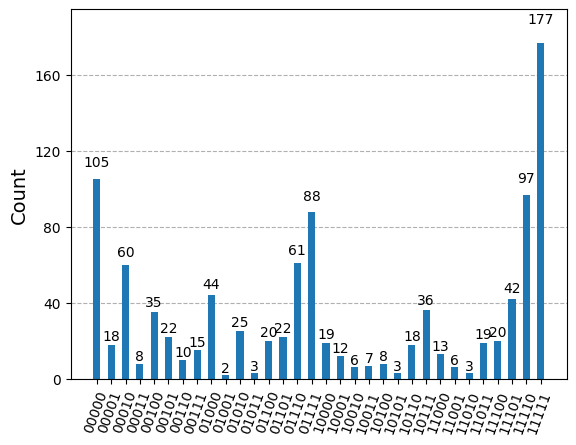

In [378]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [379]:
for measured_value in counts:
    print(f"Measured {int(measured_value[::-1], 2)}")

Measured 26
Measured 24
Measured 17
Measured 3
Measured 16
Measured 11
Measured 8
Measured 9
Measured 27
Measured 18
Measured 2
Measured 10
Measured 22
Measured 29
Measured 7
Measured 21
Measured 20
Measured 25
Measured 14
Measured 4
Measured 6
Measured 12
Measured 23
Measured 19
Measured 1
Measured 0
Measured 13
Measured 31
Measured 30
Measured 5
Measured 28
Measured 15


In [380]:
guesses_final = []

for measured_value in counts:
    measured_value_decimal = int(measured_value[::-1], 2)
    print(f"Measured {measured_value_decimal}")
    
    if measured_value_decimal % 2 != 0:
        print("Failed. Measured value is not an even number")
        continue
    x = int((a_inner ** (measured_value_decimal/2)) % N_inner)
    if (x + 1) % N_inner == 0:
        print("Failed. x + 1 = 0 (mod N) where x = a^(r/2) (mod N)")
        continue
    a, b = gcd(x + 1, N_inner), gcd(x - 1, N_inner)
    print(a, b)

    if (a != 1) and a not in guesses_final:
        guesses_final.append(a)
    
    if (b != 1) and b not in guesses_final:
        guesses_final.append(b)

Measured 26
Failed. x + 1 = 0 (mod N) where x = a^(r/2) (mod N)
Measured 24
1 21
Measured 17
Failed. Measured value is not an even number
Measured 3
Failed. Measured value is not an even number
Measured 16
1 21
Measured 11
Failed. Measured value is not an even number
Measured 8
1 21
Measured 9
Failed. Measured value is not an even number
Measured 27
Failed. Measured value is not an even number
Measured 18
Failed. x + 1 = 0 (mod N) where x = a^(r/2) (mod N)
Measured 2
Failed. x + 1 = 0 (mod N) where x = a^(r/2) (mod N)
Measured 10
Failed. x + 1 = 0 (mod N) where x = a^(r/2) (mod N)
Measured 22
Failed. x + 1 = 0 (mod N) where x = a^(r/2) (mod N)
Measured 29
Failed. Measured value is not an even number
Measured 7
Failed. Measured value is not an even number
Measured 21
Failed. Measured value is not an even number
Measured 20
1 21
Measured 25
Failed. Measured value is not an even number
Measured 14
Failed. x + 1 = 0 (mod N) where x = a^(r/2) (mod N)
Measured 4
1 21
Measured 6
Failed. x + 1

In [381]:
guesses_final

[21]

In [372]:
for f in factors_:
    if f not in guesses_final:
        guesses_final.append(f)

In [373]:
guesses_final

[3, 7, 21]

In [383]:
np.set_printoptions(threshold=np.inf)
U_inner

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [387]:
(20**3) % 21

20